In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from kafka import KafkaConsumer

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,accuracy_score, f1_score, recall_score, precision_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [4]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

for m in consumer:
    print(m.value)
    break

b'"\\u00ef\\u00bb\\u00bftimestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack\\n"'


In [5]:
# load the model from disk
import pickle

filename = 'finalized_model.sav'
static_model = pickle.load(open(filename, 'rb'))
Dynamic_model= pickle.load(open(filename, 'rb'))

In [6]:
# load static data
S_dataset = pd.read_csv('kafka_dataset.csv')

In [7]:
S_dataset['sld'] = S_dataset[['sld']].apply(LabelEncoder().fit_transform)

S_dataset['longest_word'] = S_dataset[['longest_word']].apply(LabelEncoder().fit_transform)

S_dataset.dropna(inplace=True)

S_dataset = S_dataset.drop(labels = ["entropy", "labels_max", "labels_average", 'upper', 'labels_average','len',"timestamp"], axis=1)

In [8]:
S_dataset

,FQDN_count,subdomain_length,lower,numeric,special,labels,longest_word,sld,subdomain,Target Attack
0,13,0,12,0,1,2,3256,7160,0,0
1,25,8,10,9,6,6,2,83,1,0
2,8,0,6,0,2,2,1627,3738,0,0
3,20,3,18,0,2,3,1213,10690,1,0
4,27,10,10,11,6,6,2,83,1,1
...,...,...,...,...,...,...,...,...,...,...
268059,25,8,10,9,6,6,2,83,1,0
268060,25,8,10,9,6,6,2,83,1,1
268061,24,7,10,8,6,6,4,131,1,1
268062,24,7,10,8,6,6,4,131,1,1


In [9]:
def get_thou_record(itr):
    list_with_1000_record=[]
    i=0
    for m in consumer:
        
        if i <1000:
            #print(f"recored {i+1} :", m.value)
            list_with_1000_record.append(m.value)
            i=i+1
        else:
            
            break
    print(f"Window {itr}")
   
    
    return list_with_1000_record        
        
         

In [10]:
column_names =["timestamp","FQDN_count","subdomain_length","upper","lower","numeric","entropy","special","labels","labels_max","labels_average","longest_word","sld","len","subdomain","Target Attack"]

def prepare_data( data):
    df=pd.DataFrame()
    list_of_row=[]
    for item in data:
        row_string=eval(item.decode("UTF-8"))
        row_string = row_string.strip()
        row= row_string.split(",")
        list_of_row.append(row)
    df=pd.DataFrame(list_of_row)
    df.columns=column_names
    return df
    
        

In [11]:
def data_cleaning(df):
    df['sld'] = df[['sld']].apply(LabelEncoder().fit_transform)
    
    df['longest_word'] = df[['longest_word']].apply(LabelEncoder().fit_transform)
    df.dropna(inplace=True)
    
    df = df.drop(labels = ["entropy", "labels_max", "labels_average", 'upper', 'labels_average','len',"timestamp"], axis=1)
    
    return df.astype('float')


In [12]:
def retrain_model(data):
    
    pipe = Pipeline(steps=[("scaler", StandardScaler()), ("logistic", LogisticRegression(max_iter=1500))])
    X =data.drop(labels = ["Target Attack"], axis=1) 
    y=data["Target Attack"] 
    pipe.fit(X,y)
    
    return pipe

In [14]:
## Array to save the model metric, F1 score, and added Accuracy for just checking.
list_of_ACC_Dynmaic_model=[]
list_of_ACC_static_model=[]

list_of_F1_Dynmaic_model=[]
list_of_F1_static_model=[]


for itr in range(250):
    r_dataset = get_thou_record(itr+1)
    p_dataset =  prepare_data(r_dataset)
    new_dataset =  data_cleaning(p_dataset)
    S_dataset= S_dataset.append(new_dataset)
    #split to label and featues
    X = new_dataset.drop(labels = ["Target Attack"], axis=1) 
    y = new_dataset["Target Attack"]
    
    #Dynamic model
    new_dataset.append(S_dataset)
    Dy_pred= Dynamic_model.predict(X)
    D_acc= accuracy_score(y,Dy_pred)
    D_F1= f1_score(y,Dy_pred)
    
    print(f"ACC of Dynamic Model without retrain = {D_acc*100}%")
    print(f"F1 score of Dynamic Model without retrain = {D_F1*100}%")
    
    ## Retrain model
    if D_F1 < 0.85:
        print(" \n################# The model will be trained on the new data ##################\n")
        print(" The model will be trained on the new data")
        Dynamic_model=retrain_model(new_dataset)
        Dy_pred=Dynamic_model.predict(X)
        
        D_acc=accuracy_score(y,Dy_pred)
        D_F1= f1_score(y,Dy_pred)
        print(f"ACC of Dynamic Model without retrain = {D_acc*100}%")
        print(f"F1 score of Dynamic Model without retrain = {D_F1*100}%")

    ## Static Model
    Sy_pred=static_model.predict(X)
    S_acc=accuracy_score(y,Sy_pred)
    S_F1= f1_score(y,Sy_pred)
    print(f"{'*'*20}")
    print(f"ACC of Static Model = {S_acc*100}%")
    print(f"F1 score of Static Model = {S_F1*100}%")
    
    list_of_ACC_Dynmaic_model.append(D_acc)
    list_of_ACC_static_model.append(S_acc)
    
    list_of_F1_Dynmaic_model.append(D_F1)
    list_of_F1_static_model.append(S_F1)

    
    print(f"{'*'*20}")
   

Window 1
ACC of Dynamic Model without retrain = 83.0%
F1 score of Dynamic Model without retrain = 86.4433811802233%
********************
ACC of Static Model = 83.0%
F1 score of Static Model = 86.4433811802233%
********************
Window 2
ACC of Dynamic Model without retrain = 83.39999999999999%
F1 score of Dynamic Model without retrain = 87.13178294573643%
********************
ACC of Static Model = 83.39999999999999%
F1 score of Static Model = 87.13178294573643%
********************
Window 3
ACC of Dynamic Model without retrain = 80.4%
F1 score of Dynamic Model without retrain = 83.9607201309329%
 
################# The model will be trained on the new data ##################

 The model will be trained on the new data
ACC of Dynamic Model without retrain = 80.5%
F1 score of Dynamic Model without retrain = 83.9506172839506%
********************
ACC of Static Model = 80.4%
F1 score of Static Model = 83.9607201309329%
********************
Window 4
ACC of Dynamic Model without retrain =

## Accuracy plot Vs iterations

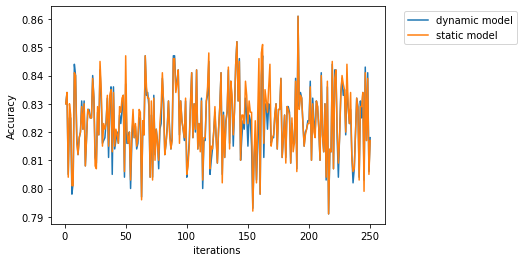

In [15]:
plt.plot(range(1, 251), list_of_ACC_Dynmaic_model, label=f'dynamic model')
plt.plot(range(1, 251),list_of_ACC_static_model, label=f'static model')
plt.xlabel('iterations ')
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

## F1 plot Vs iterations

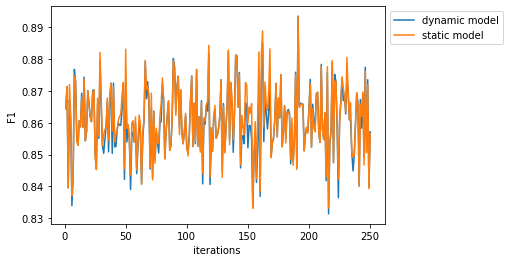

In [16]:
plt.plot(range(1, 251), list_of_F1_Dynmaic_model, label=f'dynamic model')
plt.plot(range(1, 251),list_of_F1_static_model, label=f'static model')
plt.xlabel('iterations ')
plt.ylabel("F1")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")